## Verifying Stokes Law with AI & a novel Correction Function

#### Importing external libraries

In [1]:
from collections import deque
from imutils.video import VideoStream
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import imutils
import time

#### Importing functions we made

In [2]:
from functions.discrete_differential import d_dt
from functions.pixel_shift_perspective_correction import position_to_irl

#### Importing static variables

In [3]:
from utils.static import ballLower, ballUpper, buffer

#### Declaring local variables and acquiring the video stream

In [4]:
frames_total = 0
elements = []
frame_shape = None
pts = deque(maxlen=buffer)

# Choosing the video file
vs = cv2.VideoCapture("warehouse/media_store/kerosene_v1.mp4")

#### Main tracking function

In [5]:
while True:
    frame = vs.read()
    frame = frame[1]
    if frame is None:
        break
    frames_total += 1

    frame = imutils.resize(frame, width=400)
    if frames_total == 1:
        frame_shape = frame.shape
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(hsv, ballLower, ballUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None

    if len(cnts) > 0:
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        # print vals upto 2 decimal places
        # print(f"x: {x:.2f},\t y: {y:.2f},\t radius: {radius:.2f}", end = "\t")
        M = cv2.moments(c)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        # print(f"center: {center},\t timestamp: {vs.get(cv2.CAP_PROP_POS_MSEC)}")

        # only proceed if the radius meets a minimum size
        if radius > 10:
            elements.append(
                [
                    vs.get(cv2.CAP_PROP_POS_MSEC),
                    (x, y),
                    center
                ]
            )
            # draw the circle and centroid on the frame,
            # then update the list of tracked points
            cv2.circle(frame, (int(x), int(y)), int(radius),
                (0, 255, 0), 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)

    # update the points queue
    pts.appendleft(center)

    # loop over the set of tracked points
    for i in range(1, len(pts)):
        # if either of the tracked points are None, ignore
        # them
        if pts[i - 1] is None or pts[i] is None:
            continue

        # otherwise, compute the thickness of the line and
        # draw the connecting lines
        thickness = int(np.sqrt(buffer / float(i + 1)) * 2.5)
        cv2.line(frame, pts[i - 1], pts[i], (0, 0, 255), thickness)

    # show the frame to our screen
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the 'q' key is pressed, stop the loop
    if key == ord("q"):
        break
    # time.sleep(0.05)

vs.release()
cv2.destroyAllWindows()

print(f"Length of elements: {len(elements)}\nFrames_shape: {frame_shape}")

Length of elements: 188
Frames_shape: (711, 400, 3)


#### Calculating IRL velocities using pixel shift & accounting for perspective errors

In [6]:
y_axis_vals = [element[2][1] for element in elements]
timestamps = [element[0] for element in elements]

y_irl = [position_to_irl(y_axis_val, 0.45, 0, frame_shape[0], 0.3)[1] for y_axis_val in y_axis_vals]

#### Applying the discrete differential on the Y-axis values

In [7]:
v_irl = d_dt(y_irl, timestamps)

#### Plotting various graphs to visualize the results

##### Y-Axis values

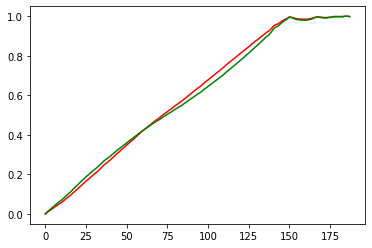

In [8]:
plt.plot([(float(i)-min(y_axis_vals))/(max(y_axis_vals)-min(y_axis_vals)) for i in y_axis_vals], color = "r")
plt.plot([(float(i)-min(y_irl))/(max(y_irl)-min(y_irl)) for i in y_irl], color = "g")

##### Velocity curve (discretely differentiated)

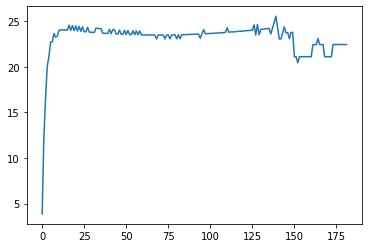

In [9]:
plt.plot(v_irl)

#### Plotting the graph along with the theoritical terminal velocity

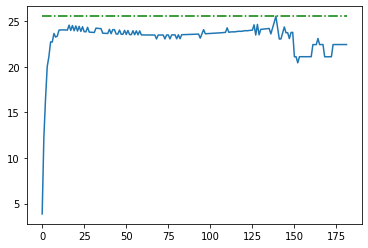

In [10]:
plt.plot(v_irl)
plt.plot([25.541] * len(v_irl), color = "green", ls = "-.")